In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT

In [1]:
# single = '/eos/user/b/bbapi/My_Analysis/Background/a8871225-62a9-4e78-a1a8-c7369ee8c474.root'   
single = '/eos/user/b/bbapi/My_Analysis/TTtoLNu2Q_22EESummerRun3.root'

In [3]:
factory = NanoEventsFactory.from_root(
    f"{single}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events = ak.materialize(events)

In [4]:
events.fields

['SubGenJetAK8',
 'FatJet',
 'genTtbarId',
 'run',
 'GenMET',
 'LHEScaleWeight',
 'OtherPV',
 'IsoTrack',
 'SoftActivityJetHT5',
 'orbitNumber',
 'GenVisTau',
 'LowPtElectron',
 'PFCand',
 'RawPuppiMET',
 'TrackGenJetAK4',
 'Electron',
 'GenPart',
 'FsrPhoton',
 'Generator',
 'DST',
 'bunchCrossing',
 'Jet',
 'PV',
 'SV',
 'Tau',
 'HLTriggerFinalPath',
 'Dataset',
 'TauSpinner',
 'GenDressedLepton',
 'GenIsolatedPhoton',
 'LHEReweightingWeight',
 'LHE',
 'PuppiMET',
 'LHEPdfWeight',
 'L1Reco',
 'GenVtx',
 'CorrT1METJet',
 'GenProton',
 'TrigObj',
 'HLT',
 'FatJetPFCand',
 'SoftActivityJetNjets10',
 'RawPFMET',
 'Pileup',
 'FiducialMET',
 'DeepMETResolutionTune',
 'Flag',
 'SoftActivityJetNjets5',
 'LHEPart',
 'Photon',
 'L1',
 'Muon',
 'PVBS',
 'TauProd',
 'HTXS',
 'GenJet',
 'boostedTau',
 'L1simulation',
 'SoftActivityJetHT',
 'BeamSpot',
 'DeepMETResponseTune',
 'SoftActivityJetHT10',
 'SubJet',
 'luminosityBlock',
 'TrkMET',
 'MC',
 'PFMET',
 'PSWeight',
 'Rho',
 'event',
 'LHEWeig

In [5]:
events.Photon.fields

['cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'seediEtaOriX',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'ecalPFClusterIso',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'hoe_PUcorr',
 'hoe_Tower',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all_quadratic',
 'pfRelIso03_chg_quadratic',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 's4',
 'sieie',
 'sieip',
 'sipip',
 'superclusterEta',
 'trkSumPtHollowConeDR03',
 'trkSumPtSolidConeDR04',
 'x_calo',
 'y_calo',
 'z_calo',
 'genPartFlav',
 'genPartIdx',
 'electronIdxG',
 'genPartIdxG',
 'jetIdxG']

In [6]:
photons = events.Photon

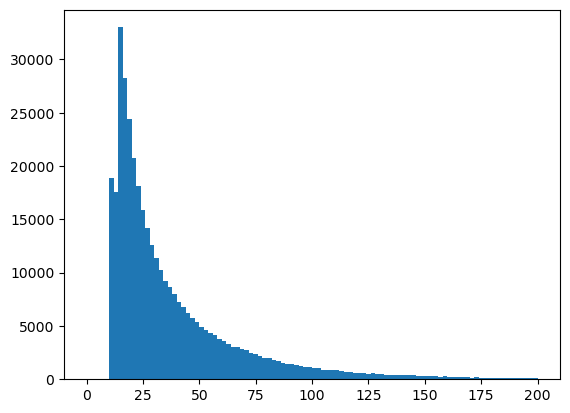

In [7]:
plt.hist(ak.flatten(photons.pt), bins = 100, range = (0,200));

In [24]:
import awkward as ak
import numpy as np

def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)


def photon_preselections_test(
    photons: ak.Array,
    events: ak.Array,
    electron_veto=True,
    revert_electron_veto=False,
    year="2018",
    IsFlag=False):
    """
    Apply full preselection on leptons, jets, and photons.
    Finally return only photons from events that pass all criteria.
    """

    print("Number of events before preselection:", len(events))

    print("Year:", year)

    # ------------------------
    # Lepton selection
    # ------------------------
    if year.startswith("2016"):
        ele_pt_cut, mu_pt_cut = 27, 26
    elif year == "2017":
        ele_pt_cut, mu_pt_cut = 33, 29
    elif year == "2018":
        # ele_pt_cut, mu_pt_cut = 33, 26
        ele_pt_cut, mu_pt_cut = 33, 26

    else:
        raise ValueError(f"Unknown year {year}")
    
    #-------------------------
    # b-tagging working point
    #-------------------------

    if year == "2016APV":
        wp_medium = 0.2598
    elif year == "2016":
        wp_medium = 0.2489
    elif year == "2017":
        wp_medium = 0.304
    elif year == "2018":
        wp_medium = 0.2783

    else:
        raise ValueError(f"Unknown year {year}")


    electrons = events.Electron

    good_electrons = (
        (electrons.pt > ele_pt_cut) &
        (np.abs(electrons.eta) < 2.5) &  # keep within tracker acceptance
        ~((np.abs(electrons.eta) > 1.44) & (np.abs(electrons.eta) < 1.57)) # remove transition
        &(electrons.mvaIso_WP80)    # tight MVA ID
        &(electrons.pfRelIso03_all < 0.15)  # isolation cut
    )

    good_muons = (
        (events.Muon.pt > mu_pt_cut)
        & (np.abs(events.Muon.eta) < 2.4)
        & (events.Muon.pfRelIso03_all < 0.15)
    )

    one_ele = ak.num(events.Electron[good_electrons]) == 1
    one_mu = ak.num(events.Muon[good_muons]) == 1
    lepton_channel_mask = one_ele | one_mu

    # one_or_more_ele = ak.num(events.Electron[good_electrons]) >= 1
    # one_or_more_mu = ak.num(events.Muon[good_muons]) >= 1
    # lepton_channel_mask = one_or_more_ele | one_or_more_mu

    # lepton_channel_mask = one_mu

    selected_electrons = events.Electron[good_electrons]
    print("selected_electrons", len(selected_electrons[ak.num(selected_electrons.pt)>0]))
    selected_muons = events.Muon[good_muons]
    print("selected_muons", len(selected_muons[ak.num(selected_muons.pt)>0]))
    selected_leptons = ak.concatenate([selected_electrons, selected_muons], axis=1)
    print("selected_leptons", len(selected_leptons[ak.num(selected_leptons.pt)>0]))
    print("selected Electrons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==11])>0]))
    print("selected Muons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==13])>0]))

    # ------------------------
    # Jet selection
    # ------------------------
    good_jets = (
        (events.Jet.pt > 20)
        & (np.abs(events.Jet.eta) < 2.4)
        & (events.Jet.btagDeepFlavB > wp_medium)
    )
    selected_bjets = events.Jet[good_jets] 
    print("selected_b_jets: ", selected_bjets)
    at_least_two_bjets = ak.num(selected_bjets) >= 2

    # keep top 2 by DeepJet score
    # top2_bjets = selected_jets[ak.argsort(selected_jets.btagDeepFlavB, ascending=False)][:, :2]

    # ------------------------
    # Photon selection (from photon_preselection output)
    # ------------------------

    abs_eta = np.abs(photons.eta)

    # Barrel–endcap transition exclusion (1.442 ≤ |η| ≤ 1.566)
    valid_eta = (abs_eta <= 2.5) & ~((abs_eta >= 1.442) & (abs_eta <= 1.566))

    # Barrel vs Endcap ID cuts
    is_barrel = abs_eta < 1.442
    is_endcap = (abs_eta > 1.566) & (abs_eta < 2.5)

    # Apply region-specific MVA thresholds
    barrel_cut = is_barrel & (photons.mvaID > -0.02)
    endcap_cut = is_endcap & (photons.mvaID > -0.26)

    # barrel_cut = is_barrel & (photons.mvaID > -0.02)
    # endcap_cut = is_endcap & (photons.mvaID > -0.26)

    # Combine everything
    good_photons = (
        (photons.pt > 10)
        & valid_eta
        & (barrel_cut | endcap_cut)
        & (~photons.pixelSeed)
    )
    selected_photons = photons[good_photons]
    at_least_two_photons = ak.num(selected_photons) >= 2

    dr = delta_r_manual(selected_leptons, selected_photons)
    dr_mask = ak.all(ak.all(dr > 0.4, axis=-1), axis=-1)

    # ΔR between electrons and photons
    dr_electrons = delta_r_manual(selected_electrons, selected_photons)

    # ΔR between muons and photons
    dr_muons = delta_r_manual(selected_muons, selected_photons)


    event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons & dr_mask
    # event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons

    # ------------------------
    # Apply mask — keep length same, empties for failed events
    # ------------------------
    empty_photons = ak.Array([[]] * len(events))
    empty_bjets = ak.Array([[]] * len(events))
    empty_leptons = ak.Array([[]] * len(events))

    filtered_photons = ak.where(event_mask, selected_photons, empty_photons)
    filtered_jets = ak.where(event_mask, selected_bjets, empty_bjets)
    filtered_leptons = ak.where(event_mask, selected_leptons, empty_leptons)


    # filtered_photons = selected_photons[event_mask]
    # filtered_jets = selected_bjets[event_mask]
    # filtered_leptons = selected_leptons[event_mask]
    # filtered_events = events[event_mask]

    return filtered_photons, filtered_jets, filtered_leptons

In [25]:
pho, jets, leps = photon_preselections_test(events.Photon, events)

Number of events before preselection: 195000
Year: 2018
selected_electrons 28588
selected_muons 47097
selected_leptons 75171
selected Electrons 28588
selected Muons 47097
selected_b_jets:  [[{jetId: 6, nConstituents: 30, nElectrons: 0, nMuons: 0, nSVs: 2, ...}], ...]


In [8]:
def photon_preselections_ggH_BBGG_with_cat(
    photons: ak.Array,
    events: ak.Array,
    electron_veto=True,
    revert_electron_veto=False,
    year="2022",
    IsFlag=False):

    print("Number of events before preselection:", len(events))
    print("Year:", year)

    # -------------------------
    # b-tagging working point
    # -------------------------
    if year in ["2022", "2022EE", "2024"]:
        wp_medium = 0.2783
    else:
        raise ValueError(f"Unknown year {year}")

    # ------------------------
    # Jet selection
    # ------------------------
    good_jets_mask = (
        (events.Jet.pt > 20.0)
        & (np.abs(events.Jet.eta) < 2.4)
    )
    good_jets = events.Jet[good_jets_mask]

    # b-tag working points
    deepflav_mask = good_jets_mask & (events.Jet.btagDeepFlavB > wp_medium)
    deepflav_bjets = events.Jet[deepflav_mask]

    upar_mask = good_jets_mask & (events.Jet.btagUParTAK4probbb > 0.38)
    upar_bjets = events.Jet[upar_mask]

    # -------------------------------
    # Orthogonal Categories
    # -------------------------------
    cat1 = ak.num(deepflav_bjets) >= 2
    cat2 = (ak.num(upar_bjets) >= 1) & (~cat1)
    cat3 = (ak.num(good_jets) == 1) & (~cat1) & (~cat2)

    # =====================================================
    # ROOT-style photon selection (NO pre-filtering!)
    # =====================================================

    # Sort photons
    sorted_idx = ak.argsort(photons.pt, ascending=False)
    pho_sorted = photons[sorted_idx]

    # Pad so iL/iS always exist
    pho_padded = ak.pad_none(pho_sorted, 2)
    iL = pho_padded[:, 0]
    iS = pho_padded[:, 1]

    # Fill None → safe values
    lead_pt = ak.fill_none(iL.pt, -999)
    sub_pt  = ak.fill_none(iS.pt, -999)

    lead_eta = ak.fill_none(iL.eta, 0)
    sub_eta  = ak.fill_none(iS.eta, 0)

    lead_mva = ak.fill_none(iL.mvaID, -999)
    sub_mva  = ak.fill_none(iS.mvaID, -999)

    lead_pix = ak.fill_none(iL.pixelSeed, 1)
    sub_pix  = ak.fill_none(iS.pixelSeed, 1)

    # photon multiplicity
    has_two_photons = ak.num(pho_sorted) >= 2

    # pT cuts
    pt_cut = (lead_pt > 30) & (sub_pt > 18)

    # eta acceptance
    abs_eta_L = np.abs(lead_eta)
    abs_eta_S = np.abs(sub_eta)

    eta_cut_L = ((abs_eta_L < 1.442) |
                 ((abs_eta_L > 1.556) & (abs_eta_L < 2.5)))
    eta_cut_S = ((abs_eta_S < 1.442) |
                 ((abs_eta_S > 1.556) & (abs_eta_S < 2.5)))

    # MVAID cuts
    mva_cut_L = ak.where(abs_eta_L < 1.442, lead_mva > -0.02, lead_mva > -0.26)
    mva_cut_S = ak.where(abs_eta_S < 1.442, sub_mva > -0.02, sub_mva > -0.26)

    # pixel seed
    pixel_cut = (lead_pix == 0) & (sub_pix == 0)

    # Final ROOT photon mask
    photon_event_mask = (
        has_two_photons &
        pt_cut &
        eta_cut_L & eta_cut_S &
        mva_cut_L & mva_cut_S &
        pixel_cut
    )

    # =====================================================
    # Final category masks including photon selection
    # =====================================================
    mask1 = cat1 & photon_event_mask
    mask2 = cat2 & photon_event_mask
    mask3 = cat3 & photon_event_mask

    print(f"Cat1 events: {ak.sum(mask1)}")
    print(f"Cat2 events: {ak.sum(mask2)}")
    print(f"Cat3 events: {ak.sum(mask3)}")

    # =====================================================
    # Final Output: EXACTLY TWO PHOTONS PER EVENT
    # =====================================================
    two_photons = pho_sorted[:, :2]   # lead/sublead only

    empty = ak.Array([[]] * len(events))

    photons_cat1 = ak.where(mask1, two_photons, empty)
    photons_cat2 = ak.where(mask2, two_photons, empty)
    photons_cat3 = ak.where(mask3, two_photons, empty)

    jets_cat1 = ak.where(mask1, deepflav_bjets, empty)
    jets_cat2 = ak.where(mask2, upar_bjets, empty)
    jets_cat3 = ak.where(mask3, good_jets, empty)

    return {
        "cat1": (photons_cat1, jets_cat1),
        "cat2": (photons_cat2, jets_cat2),
        "cat3": (photons_cat3, jets_cat3),
    }

In [9]:
Results = photon_preselections_ggH_BBGG_with_cat(photons, events)

Number of events before preselection: 260898
Year: 2022
Cat1 events: 2
Cat2 events: 0
Cat3 events: 0


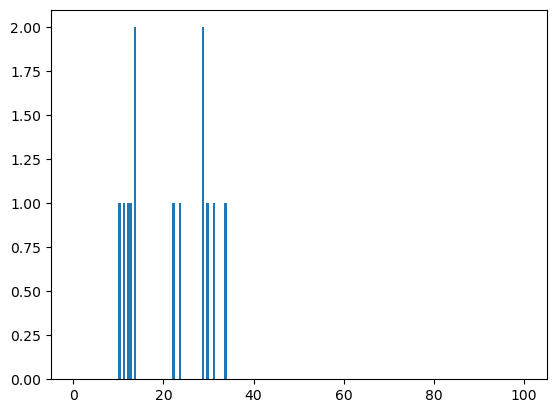

In [26]:
plt.hist(ak.flatten(pho.pt), range = (0, 100), bins = 200);

In [27]:
gen = events.GenPart

In [15]:
gen.fields

['genPartIdxMother',
 'statusFlags',
 'pdgId',
 'status',
 'eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [19]:
gen_photon = gen[gen.pdgId == 22]

In [25]:
gen_photon.genPartIdxMother

<Array [[-1, 29], [13], ..., [44, 44, 58]] type='180000 * var * int16[param...'>

In [28]:
TTG1Jets = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/Background/NTuples_BKG/TTG-1Jets_PTG-10to100_22EESummerRun3/nominal/")

In [2]:
WGtoLNuG = ak.from_parquet('/eos/user/b/bbapi/My_Analysis/Background/NTuples_BKG/WGtoLNuG-1Jets_PTG-10to100_22SummerRun3/nominal')

In [31]:
TTG1Jets.fields

['pholead_seediEtaOriX',
 'pholead_cutBased',
 'pholead_electronVeto',
 'pholead_hasConversionTracks',
 'pholead_isScEtaEB',
 'pholead_isScEtaEE',
 'pholead_mvaID_WP80',
 'pholead_mvaID_WP90',
 'pholead_pixelSeed',
 'pholead_seedGain',
 'pholead_electronIdx',
 'pholead_jetIdx',
 'pholead_seediPhiOriY',
 'pholead_vidNestedWPBitmap',
 'pholead_ecalPFClusterIso',
 'pholead_energyErr',
 'pholead_energyRaw',
 'pholead_esEffSigmaRR',
 'pholead_esEnergyOverRawE',
 'pholead_eta',
 'pholead_etaWidth',
 'pholead_haloTaggerMVAVal',
 'pholead_hcalPFClusterIso',
 'pholead_hoe',
 'pholead_hoe_PUcorr',
 'pholead_mvaID',
 'pholead_pfChargedIso',
 'pholead_pfChargedIsoPFPV',
 'pholead_pfChargedIsoWorstVtx',
 'pholead_pfPhoIso03',
 'pholead_pfRelIso03_all_quadratic',
 'pholead_pfRelIso03_chg_quadratic',
 'pholead_phi',
 'pholead_phiWidth',
 'pholead_pt',
 'pholead_r9',
 'pholead_s4',
 'pholead_sieie',
 'pholead_sieip',
 'pholead_sipip',
 'pholead_trkSumPtHollowConeDR03',
 'pholead_trkSumPtSolidConeDR04'

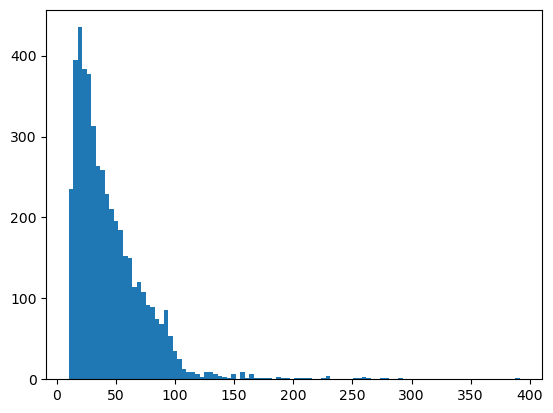

In [33]:
plt.hist(TTG1Jets.pholead_pt, bins = 100);

In [3]:
WGtoLNuG.fields

['pholead_seediEtaOriX',
 'pholead_cutBased',
 'pholead_electronVeto',
 'pholead_hasConversionTracks',
 'pholead_isScEtaEB',
 'pholead_isScEtaEE',
 'pholead_mvaID_WP80',
 'pholead_mvaID_WP90',
 'pholead_pixelSeed',
 'pholead_seedGain',
 'pholead_electronIdx',
 'pholead_jetIdx',
 'pholead_seediPhiOriY',
 'pholead_vidNestedWPBitmap',
 'pholead_ecalPFClusterIso',
 'pholead_energyErr',
 'pholead_energyRaw',
 'pholead_esEffSigmaRR',
 'pholead_esEnergyOverRawE',
 'pholead_eta',
 'pholead_etaWidth',
 'pholead_haloTaggerMVAVal',
 'pholead_hcalPFClusterIso',
 'pholead_hoe',
 'pholead_hoe_PUcorr',
 'pholead_mvaID',
 'pholead_pfChargedIso',
 'pholead_pfChargedIsoPFPV',
 'pholead_pfChargedIsoWorstVtx',
 'pholead_pfPhoIso03',
 'pholead_pfRelIso03_all_quadratic',
 'pholead_pfRelIso03_chg_quadratic',
 'pholead_phi',
 'pholead_phiWidth',
 'pholead_pt',
 'pholead_r9',
 'pholead_s4',
 'pholead_sieie',
 'pholead_sieip',
 'pholead_sipip',
 'pholead_trkSumPtHollowConeDR03',
 'pholead_trkSumPtSolidConeDR04'

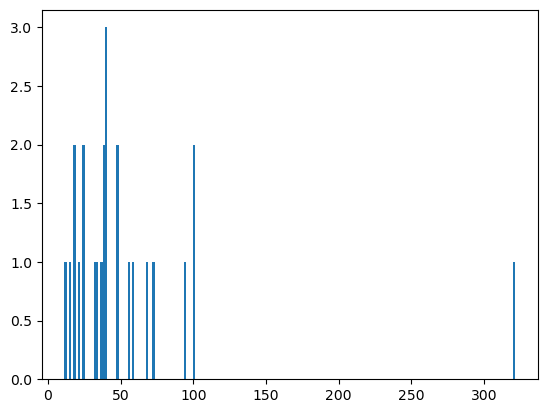

In [7]:
plt.hist(WGtoLNuG.pholead_pt, bins = 200);

In [17]:
import glob
files = glob.glob("/eos/user/b/bbapi/My_Analysis/NTuples_BKG/TTto2L2Nu_24SummerRun3/nominal/*.parquet")
a = ak.from_parquet(files)  

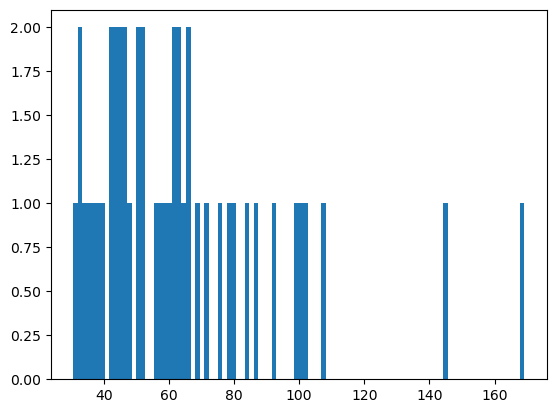

In [19]:
plt.hist(a.pholead_pt, bins = 100);

In [2]:
TTtoLNu2Q = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/NTuples_BKG_2/merged/TTtoLNu2Q_24SummerRun3/DiPho_pt_merged.parquet")
TTto2L2Nu = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/NTuples_BKG_2/merged/TTto2L2Nu_24SummerRun3/DiPho_pt_merged.parquet")

In [5]:
TTtoLNu2Q_2 = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/NTuples_BKG_ptcut_first/merged/TTtoLNu2Q_24SummerRun3/DiPho_pt_merged.parquet")
TTto2L2Nu_2 = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/NTuples_BKG_ptcut_first/merged/TTto2L2Nu_24SummerRun3/DiPho_pt_merged.parquet")

In [2]:
TTtoLNu2Q_lep = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/NTuples_BKG_lepton_presel/merged/TTtoLNu2Q_24SummerRun3/DiPho_pt_merged.parquet")
TTto2L2Nu_lep = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/NTuples_BKG_lepton_presel/merged/TTto2L2Nu_24SummerRun3/DiPho_pt_merged.parquet")

In [3]:
TTtoLNu2Q.pholead_pt

<Array [32.5, 36.9, 39, 31.5, ..., 36.4, 49.7, 44.6] type='12982 * ?float32'>

In [4]:
TTto2L2Nu.pholead_pt

<Array [84.8, 52.9, 35.7, 31.7, ..., 42.2, 162, 85.3] type='23764 * ?float32'>

In [4]:
import numpy as np

ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Your arrays (already existing)
# --------------------------------------------------
arr1 = TTtoLNu2Q.pholead_pt
arr2 = TTto2L2Nu.pholead_pt

# If awkward / numpy, make sure they are flat numpy arrays
arr1 = np.asarray(arr1)
arr2 = np.asarray(arr2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 50
xmin  = 0
xmax  = 500

h1 = ROOT.TH1F("h_TTtoLNu2Q", "Leading photon p_{T}", nbins, xmin, xmax)
h2 = ROOT.TH1F("h_TTto2L2Nu", "Leading photon p_{T}", nbins, xmin, xmax)

# Fill from arrays
for v in arr1:
    h1.Fill(v)

for v in arr2:
    h2.Fill(v)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kAzure + 1)
h2.SetFillColor(ROOT.kOrange + 7)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# --------------------------------------------------
stack = ROOT.THStack(
    "stack",
    ";Leading photon p_{T} [GeV];Events"
)

stack.Add(h1)
stack.Add(h2)

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c", "pholead_pt stack", 800, 700)
stack.Draw("HIST")

stack.SetMaximum(stack.GetMaximum() * 1.3)

# --------------------------------------------------
# Legend
# --------------------------------------------------
leg = ROOT.TLegend(0.65, 0.7, 0.88, 0.88)
leg.SetBorderSize(0)
leg.AddEntry(h1, "TTtoLNu2Q", "f")
leg.AddEntry(h2, "TTto2L2Nu", "f")
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("pholead_pt_stack.png")


Info in <TCanvas::Print>: png file pholead_pt_stack.png has been created


In [7]:
import numpy as np

ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q.pholead_pt)
arr2 = np.asarray(TTto2L2Nu.pholead_pt)

# Number of generated events (IMPORTANT)
# Ngen_1 = len(arr1)
# Ngen_2 = len(arr2)

Ngen_1 = 484475057
Ngen_2 = 470123263

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3       # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 50
xmin  = 0
xmax  = 500

h1 = ROOT.TH1F("h_TTtoLNu2Q", ";Leading photon p_{T} [GeV];Events", nbins, xmin, xmax)
h2 = ROOT.TH1F("h_TTto2L2Nu", ";Leading photon p_{T} [GeV];Events", nbins, xmin, xmax)

# Proper weighted filling
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kAzure + 1)
h2.SetFillColor(ROOT.kOrange + 7)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# --------------------------------------------------
stack = ROOT.THStack("stack", ";Leading photon p_{T} [GeV];Events")

stack.Add(h1)
stack.Add(h2)

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c", "Scaled stack", 800, 700)
c.SetLogy()
stack.Draw("HIST")
stack.SetMaximum(stack.GetMaximum() * 1.3)

# --------------------------------------------------
# Legend
# --------------------------------------------------
leg = ROOT.TLegend(0.65, 0.7, 0.88, 0.88)
leg.SetBorderSize(0)
leg.AddEntry(h1, "TTtoLNu2Q", "f")
leg.AddEntry(h2, "TTto2L2Nu", "f")
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("pholead_pt_stack_xsec_lumi_scaled.png")


Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Warning in <TROOT::Append>: Replacing existing TH1: h_TTtoLNu2Q (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_TTto2L2Nu (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file pholead_pt_stack_xsec_lumi_scaled.png has been created


In [4]:
ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q.mass)     # semi-leptonic
arr2 = np.asarray(TTto2L2Nu.mass)     # di-leptonic

# --------------------------------------------------
# Number of generated events (BEFORE preselection)
# --------------------------------------------------
Ngen_1 = 484_475_057   # TTtoLNu2Q
Ngen_2 = 470_123_263   # TTto2L2Nu

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3      # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 14
xmin  = 10
xmax  = 80

h1 = ROOT.TH1F(
    "h_TTtoLNu2Q_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

h2 = ROOT.TH1F(
    "h_TTto2L2Nu_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

# h1.SetMinimum(10.0)
# h2.SetMinimum(10.0)

# --------------------------------------------------
# Weighted filling
# --------------------------------------------------
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kCyan)   # semi-leptonic (TOP)
h2.SetFillColor(ROOT.kYellow)  # di-leptonic (BOTTOM)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# IMPORTANT: bottom FIRST, top LAST
# --------------------------------------------------
stack = ROOT.THStack(
    "stack_mass",
    ";M_{#gamma#gamma} [GeV];Events/5 GeV"
)

stack.Add(h2)   # di-leptonic → bottom
stack.Add(h1)   # semi-leptonic → TOP

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c_mass", "Mass stack", 800, 700)
c.SetLogy()

stack.Draw("HIST")
stack.SetMinimum(0.1)
stack.SetMaximum(stack.GetMaximum() * 10)

# --------------------------------------------------
# CMS style text
# --------------------------------------------------
cmsText = ROOT.TLatex()
cmsText.SetNDC()
cmsText.SetTextFont(62)      # bold
cmsText.SetTextSize(0.045)
cmsText.DrawLatex(0.12, 0.92, "CMS")

prelimText = ROOT.TLatex()
prelimText.SetNDC()
prelimText.SetTextFont(52)   # italic
prelimText.SetTextSize(0.035)
prelimText.DrawLatex(0.205, 0.92, "Preliminary")

lumiText = ROOT.TLatex()
lumiText.SetNDC()
lumiText.SetTextFont(42)
lumiText.SetTextSize(0.035)
lumiText.SetTextAlign(31)    # right-aligned
lumiText.DrawLatex(
    0.90, 0.92,
    "109 fb^{-1} (13.6 TeV, 2024)"
)


# --------------------------------------------------
# Legend (order matches visual dominance)
# --------------------------------------------------
leg = ROOT.TLegend(0.70, 0.75, 0.95, 0.90)
leg.SetBorderSize(0)
leg.SetFillStyle(0)       # transparent background
leg.SetTextSize(0.025)
leg.AddEntry(h1, "TTtoL#nu2Q", "f")   # top
leg.AddEntry(h2, "TTto2L2#nu", "f")    # bottom
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("mass_stack_xsec_lumi_scaled_log.png")




Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Warning in <TROOT::Append>: Replacing existing TH1: h_TTtoLNu2Q_mass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_TTto2L2Nu_mass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_mass
Info in <TCanvas::Print>: png file mass_stack_xsec_lumi_scaled_log.png has been created


In [3]:
ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q.mass)     # semi-leptonic
arr2 = np.asarray(TTto2L2Nu.mass)     # di-leptonic

# --------------------------------------------------
# Number of generated events (BEFORE preselection)
# --------------------------------------------------
Ngen_1 = 484_475_057   # TTtoLNu2Q
Ngen_2 = 470_123_263   # TTto2L2Nu

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3      # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 58
xmin  = 10
xmax  = 300

h1 = ROOT.TH1F(
    "h_TTtoLNu2Q_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

h2 = ROOT.TH1F(
    "h_TTto2L2Nu_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

# h1.SetMinimum(10.0)
# h2.SetMinimum(10.0)

# --------------------------------------------------
# Weighted filling
# --------------------------------------------------
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kCyan)   # semi-leptonic (TOP)
h2.SetFillColor(ROOT.kYellow)  # di-leptonic (BOTTOM)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# IMPORTANT: bottom FIRST, top LAST
# --------------------------------------------------
stack = ROOT.THStack(
    "stack_mass",
    ";M_{#gamma#gamma} [GeV];Events/5 GeV"
)

stack.Add(h2)   # di-leptonic → bottom
stack.Add(h1)   # semi-leptonic → TOP

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c_mass", "Mass stack", 800, 700)
c.SetLogy()

stack.Draw("HIST")
stack.SetMinimum(0.1)
stack.SetMaximum(stack.GetMaximum() * 10)

# --------------------------------------------------
# CMS style text
# --------------------------------------------------
cmsText = ROOT.TLatex()
cmsText.SetNDC()
cmsText.SetTextFont(62)      # bold
cmsText.SetTextSize(0.045)
cmsText.DrawLatex(0.12, 0.92, "CMS")

prelimText = ROOT.TLatex()
prelimText.SetNDC()
prelimText.SetTextFont(52)   # italic
prelimText.SetTextSize(0.035)
prelimText.DrawLatex(0.205, 0.92, "Preliminary")

lumiText = ROOT.TLatex()
lumiText.SetNDC()
lumiText.SetTextFont(42)
lumiText.SetTextSize(0.035)
lumiText.SetTextAlign(31)    # right-aligned
lumiText.DrawLatex(
    0.90, 0.92,
    "109 fb^{-1} (13.6 TeV, 2024)"
)


# --------------------------------------------------
# Legend (order matches visual dominance)
# --------------------------------------------------
leg = ROOT.TLegend(0.70, 0.75, 0.95, 0.90)
leg.SetBorderSize(0)
leg.SetFillStyle(0)       # transparent background
leg.SetTextSize(0.025)
leg.AddEntry(h1, "TTtoL#nu2Q", "f")   # top
leg.AddEntry(h2, "TTto2L2#nu", "f")    # bottom
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("mass_stack_xsec_lumi_scaled_log_300.png")

Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Info in <TCanvas::Print>: png file mass_stack_xsec_lumi_scaled_log_300.png has been created


In [6]:
ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q_2.mass)     # semi-leptonic
arr2 = np.asarray(TTto2L2Nu_2.mass)     # di-leptonic

# --------------------------------------------------
# Number of generated events (BEFORE preselection)
# --------------------------------------------------
Ngen_1 = 484_475_057   # TTtoLNu2Q
Ngen_2 = 470_123_263   # TTto2L2Nu

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3      # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 14
xmin  = 10
xmax  = 80

h1 = ROOT.TH1F(
    "h_TTtoLNu2Q_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

h2 = ROOT.TH1F(
    "h_TTto2L2Nu_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

# h1.SetMinimum(10.0)
# h2.SetMinimum(10.0)

# --------------------------------------------------
# Weighted filling
# --------------------------------------------------
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kCyan)   # semi-leptonic (TOP)
h2.SetFillColor(ROOT.kYellow)  # di-leptonic (BOTTOM)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# IMPORTANT: bottom FIRST, top LAST
# --------------------------------------------------
stack = ROOT.THStack(
    "stack_mass",
    ";M_{#gamma#gamma} [GeV];Events/5 GeV"
)

stack.Add(h2)   # di-leptonic → bottom
stack.Add(h1)   # semi-leptonic → TOP

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c_mass", "Mass stack", 800, 700)
c.SetLogy()

stack.Draw("HIST")
stack.SetMinimum(0.1)
stack.SetMaximum(stack.GetMaximum() * 10)

# --------------------------------------------------
# CMS style text
# --------------------------------------------------
cmsText = ROOT.TLatex()
cmsText.SetNDC()
cmsText.SetTextFont(62)      # bold
cmsText.SetTextSize(0.045)
cmsText.DrawLatex(0.12, 0.92, "CMS")

prelimText = ROOT.TLatex()
prelimText.SetNDC()
prelimText.SetTextFont(52)   # italic
prelimText.SetTextSize(0.035)
prelimText.DrawLatex(0.205, 0.92, "Preliminary")

lumiText = ROOT.TLatex()
lumiText.SetNDC()
lumiText.SetTextFont(42)
lumiText.SetTextSize(0.035)
lumiText.SetTextAlign(31)    # right-aligned
lumiText.DrawLatex(
    0.90, 0.92,
    "109 fb^{-1} (13.6 TeV, 2024)"
)


# --------------------------------------------------
# Legend (order matches visual dominance)
# --------------------------------------------------
leg = ROOT.TLegend(0.70, 0.75, 0.95, 0.90)
leg.SetBorderSize(0)
leg.SetFillStyle(0)       # transparent background
leg.SetTextSize(0.025)
leg.AddEntry(h1, "TTtoL#nu2Q", "f")   # top
leg.AddEntry(h2, "TTto2L2#nu", "f")    # bottom
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("mass_stack_xsec_lumi_scaled_log_2.png")




Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Warning in <TROOT::Append>: Replacing existing TH1: h_TTtoLNu2Q_mass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_TTto2L2Nu_mass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_mass
Info in <TCanvas::Print>: png file mass_stack_xsec_lumi_scaled_log_2.png has been created


In [7]:
ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q_2.mass)     # semi-leptonic
arr2 = np.asarray(TTto2L2Nu_2.mass)     # di-leptonic

# --------------------------------------------------
# Number of generated events (BEFORE preselection)
# --------------------------------------------------
Ngen_1 = 484_475_057   # TTtoLNu2Q
Ngen_2 = 470_123_263   # TTto2L2Nu

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3      # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 58
xmin  = 10
xmax  = 300

h1 = ROOT.TH1F(
    "h_TTtoLNu2Q_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

h2 = ROOT.TH1F(
    "h_TTto2L2Nu_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

# h1.SetMinimum(10.0)
# h2.SetMinimum(10.0)

# --------------------------------------------------
# Weighted filling
# --------------------------------------------------
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kCyan)   # semi-leptonic (TOP)
h2.SetFillColor(ROOT.kYellow)  # di-leptonic (BOTTOM)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# IMPORTANT: bottom FIRST, top LAST
# --------------------------------------------------
stack = ROOT.THStack(
    "stack_mass",
    ";M_{#gamma#gamma} [GeV];Events/5 GeV"
)

stack.Add(h2)   # di-leptonic → bottom
stack.Add(h1)   # semi-leptonic → TOP

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c_mass", "Mass stack", 800, 700)
c.SetLogy()

stack.Draw("HIST")
stack.SetMinimum(0.1)
stack.SetMaximum(stack.GetMaximum() * 10)

# --------------------------------------------------
# CMS style text
# --------------------------------------------------
cmsText = ROOT.TLatex()
cmsText.SetNDC()
cmsText.SetTextFont(62)      # bold
cmsText.SetTextSize(0.045)
cmsText.DrawLatex(0.12, 0.92, "CMS")

prelimText = ROOT.TLatex()
prelimText.SetNDC()
prelimText.SetTextFont(52)   # italic
prelimText.SetTextSize(0.035)
prelimText.DrawLatex(0.205, 0.92, "Preliminary")

lumiText = ROOT.TLatex()
lumiText.SetNDC()
lumiText.SetTextFont(42)
lumiText.SetTextSize(0.035)
lumiText.SetTextAlign(31)    # right-aligned
lumiText.DrawLatex(
    0.90, 0.92,
    "109 fb^{-1} (13.6 TeV, 2024)"
)


# --------------------------------------------------
# Legend (order matches visual dominance)
# --------------------------------------------------
leg = ROOT.TLegend(0.70, 0.75, 0.95, 0.90)
leg.SetBorderSize(0)
leg.SetFillStyle(0)       # transparent background
leg.SetTextSize(0.025)
leg.AddEntry(h1, "TTtoL#nu2Q", "f")   # top
leg.AddEntry(h2, "TTto2L2#nu", "f")    # bottom
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("mass_stack_xsec_lumi_scaled_log_300_2.png")

Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Warning in <TROOT::Append>: Replacing existing TH1: h_TTtoLNu2Q_mass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_TTto2L2Nu_mass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_mass
Info in <TCanvas::Print>: png file mass_stack_xsec_lumi_scaled_log_300_2.png has been created


In [3]:
ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q_lep.mass)     # semi-leptonic
arr2 = np.asarray(TTto2L2Nu_lep.mass)     # di-leptonic

# --------------------------------------------------
# Number of generated events (BEFORE preselection)
# --------------------------------------------------
Ngen_1 = 484_475_057   # TTtoLNu2Q
Ngen_2 = 470_123_263   # TTto2L2Nu

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3      # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 58
xmin  = 10
xmax  = 300

h1 = ROOT.TH1F(
    "h_TTtoLNu2Q_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

h2 = ROOT.TH1F(
    "h_TTto2L2Nu_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

# h1.SetMinimum(10.0)
# h2.SetMinimum(10.0)

# --------------------------------------------------
# Weighted filling
# --------------------------------------------------
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kCyan)   # semi-leptonic (TOP)
h2.SetFillColor(ROOT.kYellow)  # di-leptonic (BOTTOM)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# IMPORTANT: bottom FIRST, top LAST
# --------------------------------------------------
stack = ROOT.THStack(
    "stack_mass",
    ";M_{#gamma#gamma} [GeV];Events/5 GeV"
)

stack.Add(h2)   # di-leptonic → bottom
stack.Add(h1)   # semi-leptonic → TOP

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c_mass", "Mass stack", 800, 700)
c.SetLogy()

stack.Draw("HIST")
stack.SetMinimum(0.1)
stack.SetMaximum(stack.GetMaximum() * 10)

# --------------------------------------------------
# CMS style text
# --------------------------------------------------
cmsText = ROOT.TLatex()
cmsText.SetNDC()
cmsText.SetTextFont(62)      # bold
cmsText.SetTextSize(0.045)
cmsText.DrawLatex(0.12, 0.92, "CMS")

prelimText = ROOT.TLatex()
prelimText.SetNDC()
prelimText.SetTextFont(52)   # italic
prelimText.SetTextSize(0.035)
prelimText.DrawLatex(0.205, 0.92, "Preliminary")

lumiText = ROOT.TLatex()
lumiText.SetNDC()
lumiText.SetTextFont(42)
lumiText.SetTextSize(0.035)
lumiText.SetTextAlign(31)    # right-aligned
lumiText.DrawLatex(
    0.90, 0.92,
    "109 fb^{-1} (13.6 TeV, 2024)"
)


# --------------------------------------------------
# Legend (order matches visual dominance)
# --------------------------------------------------
leg = ROOT.TLegend(0.70, 0.75, 0.95, 0.90)
leg.SetBorderSize(0)
leg.SetFillStyle(0)       # transparent background
leg.SetTextSize(0.025)
leg.AddEntry(h1, "TTtoL#nu2Q", "f")   # top
leg.AddEntry(h2, "TTto2L2#nu", "f")    # bottom
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("mass_stack_xsec_lumi_scaled_log_300_lep.png")

Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Info in <TCanvas::Print>: png file mass_stack_xsec_lumi_scaled_log_300_lep.png has been created


In [4]:
ROOT.gROOT.SetBatch(True)
ROOT.gStyle.SetOptStat(0)

# --------------------------------------------------
# Inputs (already in memory)
# --------------------------------------------------
arr1 = np.asarray(TTtoLNu2Q_lep.mass)     # semi-leptonic
arr2 = np.asarray(TTto2L2Nu_lep.mass)     # di-leptonic

# --------------------------------------------------
# Number of generated events (BEFORE preselection)
# --------------------------------------------------
Ngen_1 = 484_475_057   # TTtoLNu2Q
Ngen_2 = 470_123_263   # TTto2L2Nu

# --------------------------------------------------
# Physics inputs
# --------------------------------------------------
lumi_fb = 109.0
lumi_pb = lumi_fb * 1e3      # fb^-1 → pb^-1
xsec_pb = 762.1

# Event weights
w1 = (xsec_pb * lumi_pb) / Ngen_1
w2 = (xsec_pb * lumi_pb) / Ngen_2

print("Weight TTtoLNu2Q  =", w1)
print("Weight TTto2L2Nu =", w2)

# --------------------------------------------------
# Histograms
# --------------------------------------------------
nbins = 14
xmin  = 10
xmax  = 80

h1 = ROOT.TH1F(
    "h_TTtoLNu2Q_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

h2 = ROOT.TH1F(
    "h_TTto2L2Nu_mass",
    ";M_{#gamma#gamma} [GeV];Events",
    nbins, xmin, xmax
)

# h1.SetMinimum(10.0)
# h2.SetMinimum(10.0)

# --------------------------------------------------
# Weighted filling
# --------------------------------------------------
for v in arr1:
    h1.Fill(v, w1)

for v in arr2:
    h2.Fill(v, w2)

# --------------------------------------------------
# Style
# --------------------------------------------------
h1.SetFillColor(ROOT.kCyan)   # semi-leptonic (TOP)
h2.SetFillColor(ROOT.kYellow)  # di-leptonic (BOTTOM)

h1.SetLineColor(ROOT.kBlack)
h2.SetLineColor(ROOT.kBlack)

# --------------------------------------------------
# Stack
# IMPORTANT: bottom FIRST, top LAST
# --------------------------------------------------
stack = ROOT.THStack(
    "stack_mass",
    ";M_{#gamma#gamma} [GeV];Events/5 GeV"
)

stack.Add(h2)   # di-leptonic → bottom
stack.Add(h1)   # semi-leptonic → TOP

# --------------------------------------------------
# Canvas
# --------------------------------------------------
c = ROOT.TCanvas("c_mass", "Mass stack", 800, 700)
c.SetLogy()

stack.Draw("HIST")
stack.SetMinimum(0.1)
stack.SetMaximum(stack.GetMaximum() * 10)

# --------------------------------------------------
# CMS style text
# --------------------------------------------------
cmsText = ROOT.TLatex()
cmsText.SetNDC()
cmsText.SetTextFont(62)      # bold
cmsText.SetTextSize(0.045)
cmsText.DrawLatex(0.12, 0.92, "CMS")

prelimText = ROOT.TLatex()
prelimText.SetNDC()
prelimText.SetTextFont(52)   # italic
prelimText.SetTextSize(0.035)
prelimText.DrawLatex(0.205, 0.92, "Preliminary")

lumiText = ROOT.TLatex()
lumiText.SetNDC()
lumiText.SetTextFont(42)
lumiText.SetTextSize(0.035)
lumiText.SetTextAlign(31)    # right-aligned
lumiText.DrawLatex(
    0.90, 0.92,
    "109 fb^{-1} (13.6 TeV, 2024)"
)


# --------------------------------------------------
# Legend (order matches visual dominance)
# --------------------------------------------------
leg = ROOT.TLegend(0.70, 0.75, 0.95, 0.90)
leg.SetBorderSize(0)
leg.SetFillStyle(0)       # transparent background
leg.SetTextSize(0.025)
leg.AddEntry(h1, "TTtoL#nu2Q", "f")   # top
leg.AddEntry(h2, "TTto2L2#nu", "f")    # bottom
leg.Draw()

# --------------------------------------------------
# Save
# --------------------------------------------------
c.SaveAs("mass_stack_xsec_lumi_scaled_log_lep.png")




Weight TTtoLNu2Q  = 0.17146166515647884
Weight TTto2L2Nu = 0.17669599983185685


Warning in <TROOT::Append>: Replacing existing TH1: h_TTtoLNu2Q_mass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_TTto2L2Nu_mass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_mass
Info in <TCanvas::Print>: png file mass_stack_xsec_lumi_scaled_log_lep.png has been created
